# BLE Proximity Experiment - Multi-Layered Perceptron Regressor
## Experiment based on the measurements of the BLE RSSI values according to the distance to the BLE Estimote beacon

### Imports
Imports of required libraries

In [1]:
#CSV Related
import pandas as pd
import csv

# Machine Learning
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import  accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
import sklearn
import scipy

#Graphical Display
%matplotlib inline
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()

plt.style.use('seaborn-whitegrid')

#Additional Helper Libraries
from operator import itemgetter
import re

Using TensorFlow backend.
D:\Programs\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Programs\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Programs\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Programs\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarn

<Figure size 432x288 with 0 Axes>

### Load File
Function that allows to load a file from disk

In [2]:
#Function that reads a csv file and structures the data accordingly
def load_file(filename):
    dataset = pd.read_csv(filename)
    return dataset

### Initialize Dataset
Initialization of the data from the file

In [3]:
dataset = load_file('../../distance_proximity_experiments.csv')
positions = dataset['coordinate_Y']
dataset['distance'] = positions
#distance_proximity_experiments were made with purple beacon
display(dataset)
display(dataset.shape)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-50,-50.000000,0-1 meters,0.0
1,0.0,0.0,-50,-50.000000,0-1 meters,0.0
2,0.0,0.0,-53,-51.000000,0-1 meters,0.0
3,0.0,0.0,-51,-51.000000,0-1 meters,0.0
4,0.0,0.0,-53,-53.000000,0-1 meters,0.0
...,...,...,...,...,...,...
456,0.0,4.0,-83,-84.250000,3-4 meters,4.0
457,0.0,4.0,-86,-84.600000,3-4 meters,4.0
458,0.0,4.0,-87,-85.000000,3-4 meters,4.0
459,0.0,4.0,-86,-85.142857,3-4 meters,4.0


(461, 6)

### File Overall Description
Usage of describe pandas function on the dataset

In [4]:
display(dataset.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
coordinate_X,461.0,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0
coordinate_Y,461.0,1.973970,1.274489,0.0,1.0,2.00,3.0,4.0
rssi_Value,461.0,-78.206074,9.461756,-94.0,-85.0,-81.00,-75.0,-50.0
rolling_mean_rssi,461.0,-78.065939,9.240107,-91.0,-84.0,-81.25,-76.0,-50.0
distance,461.0,1.973970,1.274489,0.0,1.0,2.00,3.0,4.0


### Scanned Distances
Graphical display of the distances scanned in the experiment

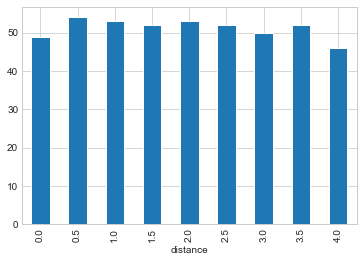

In [5]:
reference_points = dataset.groupby(['distance'])
reference_points.size().plot(kind="bar")

### Beacon RSSI Display
Graphical display of the rssi values recorded at each position

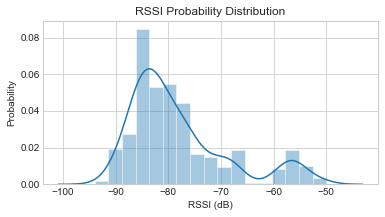

In [6]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')

sns.distplot(dataset['rssi_Value'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Beacon Rolling Mean RSSI Display
Graphical adisplay of the rolling mean value recorded at each position

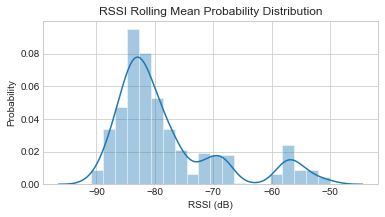

In [7]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Rolling Mean Probability Distribution')
# The KDE plot for the Rolling Mean column
sns.distplot(dataset['rolling_mean_rssi'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Graphical Display of RSSI/Rolling Mean Distribution
Graphical display of the previous measures - rssi and rolling mean

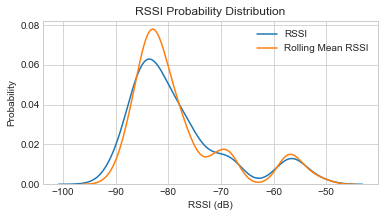

In [8]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')
# The KDE plot for the RSSI column
sns.kdeplot(dataset['rssi_Value'], label='RSSI')
# The KDE plot for the Rolling Mean column
sns.kdeplot(dataset['rolling_mean_rssi'], label='Rolling Mean RSSI')
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Features Histograms

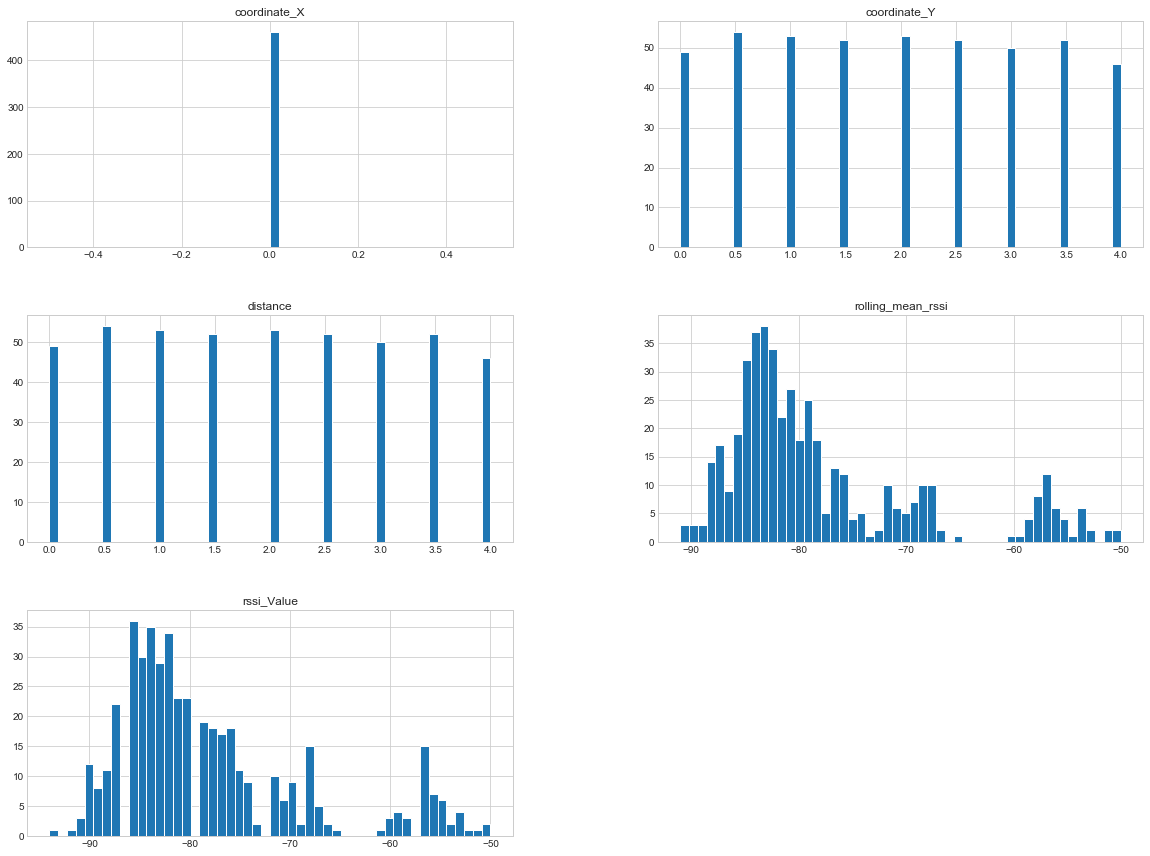

In [9]:
dataset.hist(bins=50, figsize=(20,15))
plt.show()

### Initialize Training Data
Training Data intialization for predictions purposes

In [10]:
train_X_rssi = pd.DataFrame(dataset['rssi_Value']).values
train_X_rolling_mean = pd.DataFrame(dataset['rolling_mean_rssi']).values
train_Y = pd.DataFrame(dataset['distance']).values
combination_features_X = dataset[['rssi_Value','rolling_mean_rssi']].values
default_groups = dataset['distance'].map(str)
data_plot_means = dataset.groupby(['distance'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
distance,,
0.0,-56.142857,-55.970408
0.5,-69.648148,-69.613316
1.0,-80.830189,-81.069969
1.5,-78.211538,-78.589148
2.0,-81.660377,-81.347469
2.5,-82.692308,-82.339034
3.0,-85.580000,-85.826857
3.5,-82.903846,-82.107601
4.0,-86.347826,-85.856548


### Initialize Hyperparameters for tunning

In [11]:
#Preprocessing options
scaler = [StandardScaler(),MaxAbsScaler(),MinMaxScaler(),None]
# Batch size of samples
batch_size = [10, 20, 40, 60, 80, 100]
# Epochs 
epochs = [10, 50, 100]
# Optimization function
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# Learning Rate - only used with SGD optimizer
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
# Momentum - only used with SGD optimizer
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
# Activation Function
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
# Number of neurons in a hidden layer
neurons = [100,300,400,500,600]

### Plot Training Data
Graphical Display of the observations in the dataset

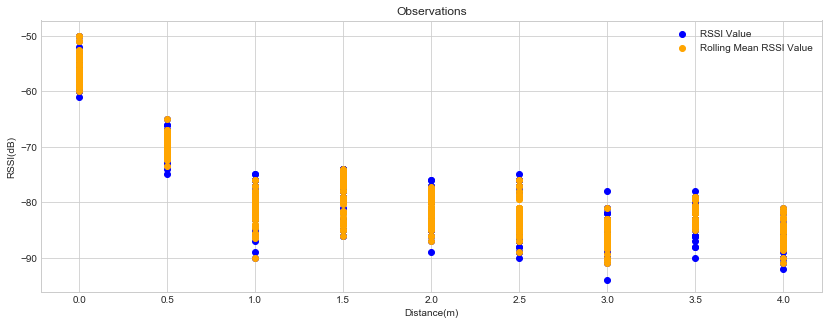

In [12]:
plt.figure(figsize=(14,5))
plt.scatter(dataset['distance'],dataset['rssi_Value'],label='RSSI Value',color='blue')
plt.scatter(dataset['distance'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Distance(m)')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Statistics Output Format
Structure of the statistical output of each call to the machine learning algorithm

In [13]:
def structure_data(data,rsquared):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    std = data['error'].std()
    q25 = data['error'].quantile(q=0.25)
    q50= data['error'].quantile(q=0.5)
    q75 =data['error'].quantile(q=0.7)
    q95= data['error'].quantile(q=0.95)
    r_squared = rsquared
    minValue= data['error'].min()
    maxValue = data['error'].max()
    statistical_results = [mae,mse,rsme,std,q25,q50,q75,q95,minValue,maxValue,r_squared]
    return statistical_results

### MLP Regressor Experiments
Experiments with MLP algorithm

In [14]:
num_neurons_basic = len(train_X_rolling_mean)
print("Default number of neurons: " + str(num_neurons_basic))
# Function to create model, required for KerasClassifier
def create_model(dim=2,num_neurons=num_neurons_basic,activation ='relu',optimizer = 'adam'):
    model = Sequential()
    model.add(Dense(num_neurons,input_dim=dim,activation=activation))
    model.add(Dense(num_neurons,activation=activation))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer=optimizer,metrics=['accuracy','mean_absolute_error'])
    return model
model = create_model()
display(model.summary())

Default number of neurons: 461
Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 461)               1383      
_________________________________________________________________
dense_2 (Dense)              (None, 461)               212982    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 462       
Total params: 214,827
Trainable params: 214,827
Non-trainable params: 0
_________________________________________________________________


None

In [15]:
def compute_MLP_Regressor(flag=0,dim=2,
                              trainX_data = None, trainY_data = None,
                              testX_data = None,testY_data = None, 
                              scaler = None,cross_validation = None,batch_size=10,epochs=50,verbose=0):
    keras_regressor = KerasRegressor(build_fn=create_model,dim=dim,epochs=epochs,batch_size=batch_size,verbose=verbose)
    seed = 7
    np.random.seed(seed)
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler,keras_regressor)
    else:
        main_estimator = keras_regressor
    if cross_validation is None:
        # Fit the training data
        main_estimator.fit(trainX_data,trainY_data)
        # Predict the results of the testing data features
        predict_test = main_estimator.predict(testX_data)
        coefficient_determination = sklearn.metrics.r2_score(testY_data,predict_test)
    else:
        print("Cross Validation Activated. CV = " + str(cross_validation))
        predict_test = cross_val_predict(main_estimator,testX_data,testY_data,cv = cross_validation,groups=default_groups)
        coefficient_determination = sklearn.metrics.r2_score(testY_data,predict_test)
    statistical_array = list()
    error_dataframe = pd.DataFrame({'Actual': testY_data.flatten(), 'Predicted':predict_test.flatten()})
    observed_errors = error_dataframe['Predicted'] - error_dataframe['Actual']
    error = pd.DataFrame(observed_errors, columns=["error"])
    result = pd.DataFrame(train_Y,columns=["distance"]).join(error)
    return structure_data(result,coefficient_determination)

#### Experiment model validity

In [73]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
result = compute_MLP_Regressor(trainX_data=combination_features_X,trainY_data=train_Y,
                                   testX_data=combination_features_X,testY_data=train_Y,
                                   scaler=StandardScaler(),verbose=0)
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared
0,0.526211,0.498627,0.706135,0.704979,-0.472305,0.047405,0.302787,1.326585,-1.610912,2.527695,0.692357


#### Try with validation_split

Train on 322 samples, validate on 139 samples
Epoch 1/50
322/322 [==============================] - 1s 3ms/step - loss: 12.2893 - accuracy: 0.0590 - mean_absolute_error: 2.7142 - val_loss: 3.1754 - val_accuracy: 0.0000e+00 - val_mean_absolute_error: 1.7367
Epoch 2/50
322/322 [==============================] - 0s 655us/step - loss: 0.7116 - accuracy: 0.1801 - mean_absolute_error: 0.7178 - val_loss: 4.9810 - val_accuracy: 0.0000e+00 - val_mean_absolute_error: 2.1961
Epoch 3/50
322/322 [==============================] - 0s 791us/step - loss: 0.6087 - accuracy: 0.1646 - mean_absolute_error: 0.6888 - val_loss: 7.4049 - val_accuracy: 0.0000e+00 - val_mean_absolute_error: 2.6922
Epoch 4/50
322/322 [==============================] - 0s 756us/step - loss: 0.8662 - accuracy: 0.1739 - mean_absolute_error: 0.7894 - val_loss: 4.5317 - val_accuracy: 0.0000e+00 - val_mean_absolute_error: 2.0912
Epoch 5/50
322/322 [==============================] - 0s 711us/step - loss: 0.7516 - accuracy: 0.1460 - mea

<Figure size 864x432 with 0 Axes>

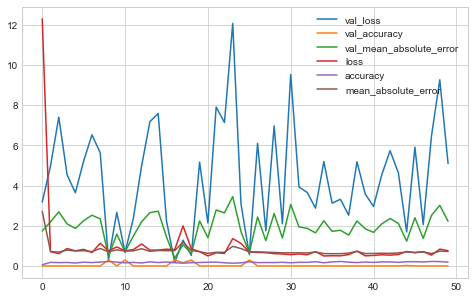

461/461 [==============================] - 0s 72us/step


[1.9058468884863202, 0.2125813513994217, 1.0873959064483643]

In [74]:
model = create_model(dim=1)
history = model.fit(train_X_rolling_mean,train_Y,validation_split=0.3,batch_size = 10,epochs=50,verbose=1)
plt.figure(figsize=(12,6))
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()
model.evaluate(train_X_rolling_mean,train_Y,verbose=1)

#### 1st Experiment - Check Model validity (Without Testing Data) Using RSSI
Use MLP to check the results on the training data alone

In [75]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
result = compute_MLP_Regressor(trainX_data=train_X_rssi,dim=1,trainY_data=train_Y,
                                   testX_data=train_X_rssi,testY_data=train_Y,
                                   scaler=StandardScaler(),verbose=0)
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)compute_MLP_Regressor

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared
0,0.566525,0.569401,0.754587,0.755342,-0.531348,0.014254,0.297364,1.324558,-1.720728,2.297364,0.648691


#### 2nd Experiment - Check Model validity (Without Testing Data) Using Rolling Mean
Use MLP to check the results on the training data alone

In [76]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
result = compute_MLP_Regressor(trainX_data=train_X_rolling_mean,dim=1,trainY_data=train_Y,
                                   testX_data=train_X_rolling_mean,testY_data=train_Y,
                                   scaler=StandardScaler(),verbose=0)
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared
0,0.549452,0.56258,0.750053,0.750506,-0.32644,0.051983,0.202409,1.375152,-1.722682,2.557982,0.652899


#### MLP with StratifiedKFold 
Experiment using cross validation approach of StratifiedKFold

Cross Validation Activated. CV = <generator object _BaseKFold.split at 0x000001F0B450F5C8>
Cross Validation Activated. CV = <generator object _BaseKFold.split at 0x000001F0E91792C8>
Cross Validation Activated. CV = <generator object _BaseKFold.split at 0x000001F09BB1D9C8>
Cross Validation Activated. CV = <generator object _BaseKFold.split at 0x000001F0EAE22948>
Cross Validation Activated. CV = <generator object _BaseKFold.split at 0x000001F0A638AE48>
Cross Validation Activated. CV = <generator object _BaseKFold.split at 0x000001F0E91792C8>
Cross Validation Activated. CV = <generator object _BaseKFold.split at 0x000001F08ADD8DC8>
Cross Validation Activated. CV = <generator object _BaseKFold.split at 0x000001F0F67B0C48>
Cross Validation Activated. CV = <generator object _BaseKFold.split at 0x000001F10228D648>
Cross Validation Activated. CV = <generator object _BaseKFold.split at 0x000001F10BA6DB48>
Cross Validation Activated. CV = <generator object _BaseKFold.split at 0x000001F0CD7CFDC8>

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,folds,type
10,0.568476,0.579350,0.761150,0.760024,-0.484432,-0.025604,0.185578,1.227147,-1.864905,2.808503,0.642552,4,Both
9,0.575167,0.552482,0.743292,0.736414,-0.652394,-0.138563,0.119205,1.236345,-1.872137,2.360320,0.659129,3,Both
2,0.591585,0.599748,0.774434,0.774941,-0.506609,0.034028,0.270760,1.318124,-1.913295,2.309920,0.629968,4,RSSI Only
6,0.595243,0.638807,0.799254,0.799946,-0.458907,-0.001486,0.224174,1.430879,-2.057694,2.627824,0.605869,4,Rolling Mean RSSI
0,0.597399,0.598107,0.773374,0.772759,-0.416648,-0.007538,0.352652,1.453332,-1.714687,2.497388,0.630980,2,RSSI Only
1,0.601677,0.596862,0.772569,0.773004,-0.499817,-0.049721,0.315054,1.431069,-1.815092,2.378907,0.631748,3,RSSI Only
5,0.607157,0.615631,0.784622,0.784270,-0.460875,-0.120419,0.281784,1.408001,-1.831095,2.362015,0.620168,3,Rolling Mean RSSI
4,0.609374,0.638541,0.799088,0.799103,-0.427141,-0.031406,0.343668,1.463039,-1.649201,2.912982,0.606033,2,Rolling Mean RSSI
8,0.611023,0.629716,0.793547,0.785650,-0.391056,0.011334,0.417955,1.551826,-1.621320,3.096978,0.611478,2,Both
11,0.615705,0.682627,0.826212,0.791440,-0.258886,0.136338,0.520534,1.694655,-1.563510,3.161013,0.578833,5,Both


Number of Folds:  4


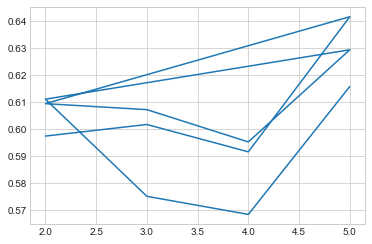

In [78]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','folds','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
cross_validation_list = np.arange(2,6)
results = list()
dim = 2
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    for cv in cross_validation_list:
        skf = StratifiedKFold(n_splits=cv)
        splited = skf.split(train_X_rssi,default_groups,default_groups)
        result = compute_MLP_Regressor(flag = 0,testX_data=trainX_data,dim=dim,epochs=25,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited)  
        result.append(cv)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['folds'],statistics['mae'])
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

#### Experiment - MLP with HoldOut
Experiment using cross validation approach of HoldOut (Train test split)

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,test_size,type
15,0.627315,0.654652,0.809105,0.795390,-0.692015,0.011791,0.330653,0.999949,-2.000051,2.278882,0.595576,0.7,Rolling Mean RSSI
6,0.610083,0.657931,0.811130,0.781417,-0.824981,-0.035818,0.146739,0.991032,-2.000448,1.925199,0.593550,0.7,RSSI Only
24,0.604503,0.613517,0.783273,0.768032,-0.798383,0.036983,0.260222,0.983368,-1.846450,2.280665,0.620988,0.7,Both
7,0.602933,0.601858,0.775795,0.771385,-0.632004,-0.048798,0.267044,1.200699,-1.799301,2.207685,0.628680,0.8,RSSI Only
8,0.601110,0.586901,0.766094,0.767016,-0.556157,0.021689,0.353293,1.328842,-1.671158,2.333310,0.636464,0.9,RSSI Only
5,0.596384,0.575326,0.758502,0.757612,-0.484650,0.085391,0.412969,1.307288,-1.542650,2.021355,0.645322,0.6,RSSI Only
4,0.583098,0.577068,0.759650,0.747561,-0.663298,-0.034199,0.181366,1.025002,-1.775134,1.504753,0.641774,0.5,RSSI Only
25,0.573250,0.573461,0.757272,0.749514,-0.671127,-0.013363,0.174216,1.094028,-1.816454,2.457307,0.646200,0.8,Both
16,0.570261,0.595225,0.771508,0.765334,-0.554234,-0.038057,0.153038,1.181074,-1.903963,2.534076,0.632772,0.8,Rolling Mean RSSI
26,0.569407,0.555506,0.745323,0.744624,-0.468921,-0.053566,0.222820,1.256836,-1.743164,2.506612,0.655910,0.9,Both


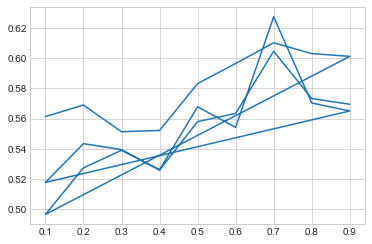

In [79]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','test_size','type']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
types = ['RSSI Only','Rolling Mean RSSI','Both']
cross_validation_list = np.arange(2,6)
results = list()
dim = 2
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    for size in test_sizes:
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y, test_size = size, random_state = 6,stratify=default_groups)
        result = compute_MLP_Regressor(dim=dim,epochs=25,trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
        result.append(size)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae'],ascending=False))
plt.plot(statistics['test_size'],statistics['mae'])

#### Experiment - MLP with LOGO
Experiment using cross validation approach of Leave One Group Out

In [80]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
dim = 2
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    cv = LeaveOneGroupOut()
    splited = cv.split(train_X_rssi,train_Y,groups=default_groups)
    loo = compute_MLP_Regressor(testX_data=trainX_data,dim=dim,epochs=25,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited) 
    loo.append(scannedType)
    results.append(loo)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

Cross Validation Activated. CV = <generator object BaseCrossValidator.split at 0x000001F11B9422C8>
Cross Validation Activated. CV = <generator object BaseCrossValidator.split at 0x000001F136B61F48>
Cross Validation Activated. CV = <generator object BaseCrossValidator.split at 0x000001F1226D3A48>


,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,type
1,0.762325,0.967844,0.983791,0.978785,-0.289350,0.134015,0.574323,1.757485,-1.837597,2.572222,0.402859,Rolling Mean RSSI
2,0.801553,0.968979,0.984367,0.979483,-0.715414,0.264735,0.561834,1.604758,-1.837231,2.590072,0.402159,Both
0,0.802045,0.978004,0.988941,0.983676,-0.451222,0.231405,0.622993,1.689813,-1.826884,2.387067,0.396591,RSSI Only


#### Experiment - Best cross-validation technique
Best parameters found using MLP

Epoch 1/25
276/276 [==============================] - 3s 11ms/step - loss: 2.4340 - accuracy: 0.1703 - mean_absolute_error: 1.1831: 1s - loss: 2.9727 - accuracy: 0.1450 - mean_absolute_error: 
Epoch 2/25
276/276 [==============================] - 1s 2ms/step - loss: 0.8299 - accuracy: 0.2609 - mean_absolute_error: 0.6781
Epoch 3/25
276/276 [==============================] - 0s 2ms/step - loss: 0.7045 - accuracy: 0.2609 - mean_absolute_error: 0.6467
Epoch 4/25
276/276 [==============================] - 1s 2ms/step - loss: 0.6715 - accuracy: 0.2174 - mean_absolute_error: 0.6629
Epoch 5/25
276/276 [==============================] - 1s 2ms/step - loss: 0.6723 - accuracy: 0.2681 - mean_absolute_error: 0.6382
Epoch 6/25
276/276 [==============================] - 0s 2ms/step - loss: 0.6881 - accuracy: 0.2717 - mean_absolute_error: 0.6280
Epoch 7/25
276/276 [==============================] - 1s 2ms/step - loss: 0.6388 - accuracy: 0.2681 - mean_absolute_error: 0.6261: 0s - loss: 0.4879 - accura

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,method,type
7,0.525890,0.465157,0.682025,0.683511,-0.421269,0.071478,0.274867,1.216840,-1.473314,1.574768,0.713174,HoldOut,Both
4,0.526128,0.513511,0.716597,0.708682,-0.513904,-0.060148,0.086395,1.089677,-1.753323,1.659206,0.683358,HoldOut,Rolling Mean RSSI
1,0.552132,0.533463,0.730385,0.727298,-0.464782,-0.025165,0.181067,1.126985,-1.696628,1.643583,0.671055,HoldOut,RSSI Only
8,0.567950,0.578593,0.760653,0.759456,-0.484430,-0.016199,0.186139,1.224538,-1.864906,2.808502,0.643020,Stratified K-Fold,Both
2,0.592491,0.600315,0.774800,0.775314,-0.506690,0.027602,0.270281,1.313172,-1.918226,2.309181,0.629618,Stratified K-Fold,RSSI Only
5,0.593641,0.636113,0.797567,0.798145,-0.486008,-0.004031,0.208403,1.412135,-2.057812,2.627825,0.607531,Stratified K-Fold,Rolling Mean RSSI
3,0.762253,0.967723,0.983729,0.978720,-0.285367,0.134015,0.574323,1.758282,-1.840790,2.574826,0.402934,LOO,Rolling Mean RSSI
6,0.800954,0.969051,0.984404,0.979618,-0.717213,0.263651,0.560008,1.609447,-1.837231,2.590082,0.402115,LOO,Both
0,0.801662,0.978155,0.989017,0.983530,-0.451813,0.223635,0.620920,1.688228,-1.821980,2.387009,0.396498,LOO,RSSI Only


Selected cross validation method:  HoldOut


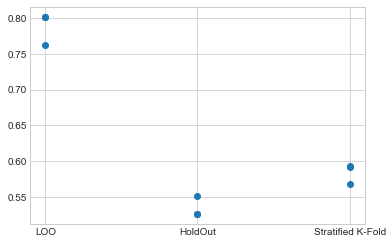

In [82]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','method','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
dim = 2
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y, test_size = 0.4, random_state = 6,stratify=default_groups)
    holdout = compute_MLP_Regressor(verbose=1,dim=dim,epochs=25,trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    cv = LeaveOneGroupOut()
    splited = cv.split(trainX_data,train_Y,groups=default_groups)
    loo = compute_MLP_Regressor(testX_data=trainX_data,dim=dim,epochs=25,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited) 
    loo.append('LOO')
    loo.append(scannedType)
    results.append(loo)
    holdout.append('HoldOut')
    holdout.append(scannedType)
    results.append(holdout)
    skf = StratifiedKFold(n_splits=selected_fold)
    splited = skf.split(train_X_rssi,default_groups,default_groups)
    skfold = compute_MLP_Regressor(flag = 0,testX_data=trainX_data,dim=dim,epochs=25,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited)  
    skfold.append('Stratified K-Fold')
    skfold.append(scannedType)
    results.append(skfold)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['method'],statistics['mae'],'o')
selected_method = statistics.sort_values(by=['mae'])['method'].head(1).values[0]
print("Selected cross validation method: ",selected_method)

#### Experiment - Best preprocessing technique
Experiment with the different preprocessing techniques

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,preprocessing,preprocessingFunc,type
8,0.525361,0.464574,0.681597,0.683126,-0.421463,0.072038,0.273791,1.209633,-1.472585,1.575083,0.713533,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",Both
9,0.525886,0.465099,0.681982,0.683471,-0.416258,0.073501,0.278100,1.213546,-1.471033,1.578587,0.713210,MaxAbsScaler,MaxAbsScaler(copy=True),Both
10,0.525890,0.465157,0.682024,0.683511,-0.421273,0.071472,0.274864,1.216838,-1.473315,1.574764,0.713174,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",Both
11,0.525890,0.465157,0.682024,0.683511,-0.421273,0.071474,0.274864,1.216838,-1.473315,1.574764,0.713174,None,None,Both
5,0.526129,0.513511,0.716597,0.708682,-0.513904,-0.060148,0.086393,1.089677,-1.753323,1.659206,0.683358,MaxAbsScaler,MaxAbsScaler(copy=True),Rolling Mean RSSI
6,0.526129,0.513511,0.716597,0.708682,-0.513904,-0.060148,0.086393,1.089677,-1.753323,1.659206,0.683358,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",Rolling Mean RSSI
7,0.526129,0.513511,0.716597,0.708682,-0.513904,-0.060148,0.086393,1.089677,-1.753323,1.659206,0.683358,None,None,Rolling Mean RSSI
4,0.526129,0.513511,0.716597,0.708682,-0.513904,-0.060148,0.086393,1.089677,-1.753323,1.659206,0.683358,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",Rolling Mean RSSI
0,0.551873,0.532980,0.730055,0.726801,-0.462888,-0.028264,0.179787,1.127192,-1.696971,1.644355,0.671352,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",RSSI Only
2,0.551873,0.532980,0.730055,0.726801,-0.462888,-0.028264,0.179787,1.127192,-1.696971,1.644355,0.671352,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",RSSI Only


Selected Preprocessing:  StandardScaler


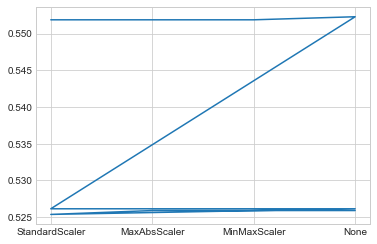

In [83]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','preprocessing','preprocessingFunc','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
dim = 2
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    for preprocess in scaler:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(train_X_rssi,train_Y,groups=default_groups)
            loo = compute_MLP_Regressor(flag = 0,testX_data=trainX_data,dim=dim,epochs=25,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited) 
        elif selected_method =='Stratified K-Fold':
            skf = StratifiedKFold(n_splits=cv)
            splited = skf.split(train_X_rssi,default_groups,default_groups)
            result = compute_MLP_Regressor(flag = 0,testX_data=trainX_data,dim=dim,epochs=25,testY_data=train_Y,scaler=StandardScaler(),cross_validation = selected_fold)  
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y, test_size = 0.4, random_state = 6,stratify=default_groups)
            result = compute_MLP_Regressor(dim=dim,epochs=25,trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
        if(preprocess is None):
            regex = 'None'
        else:
            regex = re.search('(\w+)\(',str(preprocess)).group(1)
        result.append(regex)
        result.append(preprocess)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['preprocessing'],statistics['mae'])
selected_preprocessing = statistics.sort_values(by=['mae'])['preprocessing'].head(1).values[0]
selected_preprocesssing_func = statistics.sort_values(by=['mae'])['preprocessingFunc'].head(1).values[0]
print("Selected Preprocessing: ",selected_preprocessing)

### Run RandomSearchCV for parameter tunning

In [28]:
score = 'neg_mean_absolute_error'
scaler = StandardScaler()
scaler.fit(train_X_rolling_mean)
tr = scaler.transform(train_X_rolling_mean)
model = KerasRegressor(build_fn=create_model,dim=1,epochs=50,batch_size=10,verbose=0)
param_grid = dict(activation=activation,optimizer=optimizer,num_neurons=neurons)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                          cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=6).split(trainX_data,default_groups,default_groups),
                          scoring=score,random_state=42)
display(grid)
grid_result = grid.fit(tr.reshape(-1,1), train_Y.reshape(-1,1))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000002198D7F1E48>,
                   error_score=nan,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x0000021985776808>,
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'activation': ['softmax', 'softplus',
                                                       'softsign', 'relu',
                                                       'tanh', 'sigmoid',
                                                       'hard_sigmoid',
                                                       'linear'],
                                        'num_neurons': [100, 300, 400, 500,
                                                        600],
                                        'optimizer': ['SGD', 'RMSprop',
                                                      'Adagrad', 'Adadelta',
                                                      'Adam', 'Adam

Best: -0.565751 using {'optimizer': 'Adadelta', 'num_neurons': 100, 'activation': 'relu'}


### Best Results
Compute MLP with the best parameters

In [31]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
dim = 2
selected_method = 'HoldOut'
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(train_X_rssi,train_Y,groups=default_groups)
        loo = compute_MLP_Regressor(flag = 0,verbose=1,testX_data=trainX_data,dim=dim,epochs=25,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited) 
    elif selected_method =='Stratified K-Fold':
        skf = StratifiedKFold(n_splits=cv)
        splited = skf.split(train_X_rssi,default_groups,default_groups)
        result = compute_MLP_Regressor(flag = 0,verbose=1,testX_data=trainX_data,dim=dim,epochs=25,testY_data=train_Y,scaler=StandardScaler(),cross_validation = selected_fold)  
    else:
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y, test_size = 0.4, random_state = 6,stratify=default_groups)
        result = compute_MLP_Regressor(dim=dim,epochs=25,verbose=1,trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    result.append(scannedType)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

Epoch 1/25
276/276 [==============================] - 2s 7ms/step - loss: 2.4340 - accuracy: 0.1703 - mean_absolute_error: 1.1830
Epoch 2/25
276/276 [==============================] - 0s 1ms/step - loss: 0.8311 - accuracy: 0.2609 - mean_absolute_error: 0.6786
Epoch 3/25
276/276 [==============================] - 0s 1ms/step - loss: 0.7042 - accuracy: 0.2609 - mean_absolute_error: 0.6467
Epoch 4/25
276/276 [==============================] - 0s 1ms/step - loss: 0.6711 - accuracy: 0.2174 - mean_absolute_error: 0.6626
Epoch 5/25
276/276 [==============================] - 0s 1ms/step - loss: 0.6722 - accuracy: 0.2681 - mean_absolute_error: 0.6380
Epoch 6/25
276/276 [==============================] - 0s 1ms/step - loss: 0.6880 - accuracy: 0.2717 - mean_absolute_error: 0.6279
Epoch 7/25
276/276 [==============================] - 0s 1ms/step - loss: 0.6389 - accuracy: 0.2681 - mean_absolute_error: 0.6265: 0s - loss: 0.4413 - accuracy: 0.3000 - mean_absolute_err
Epoch 8/25
276/276 [============

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,type
1,0.523923,0.512886,0.716161,0.708657,-0.513335,-0.056839,0.086641,1.089848,-1.753329,1.660126,0.683743,Rolling Mean RSSI
2,0.525477,0.464655,0.681656,0.683163,-0.410016,0.074731,0.272643,1.208897,-1.476573,1.581546,0.713483,Both
0,0.552026,0.533392,0.730337,0.727326,-0.465319,-0.023238,0.181522,1.126987,-1.696220,1.643491,0.671098,RSSI Only
